# Carregando Datasets

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Criando DataFrames

In [ ]:
import pandas as pd
import os

# Caminhos dos diretórios
code_data_path = '/content/drive/MyDrive/Arquivos_Mestrado_Arthur_Ramires/Metodologia/AnalysisData_Code'
community_data_path = '/content/drive/MyDrive/Arquivos_Mestrado_Arthur_Ramires/Metodologia/AnalysisData_Community'
output_path = '/content/drive/MyDrive/Arquivos_Mestrado_Arthur_Ramires/Metodologia/AnalysisResults/ConsolidatedMetrics.csv'

# Listas de métricas de interesse
code_metrics = ['NOF', 'NOPF', 'NOM', 'NOPM', 'LOC', 'WMC', 'NC', 'DIT', 'LCOM', 'FANIN', 'FANOUT']
community_metrics = ['CommitCount', 'DaysActive', 'AuthorCount', 'SponsoredAuthorCount',
                     'PercentageSponsoredAuthors', 'TimezoneCount', 'AuthorActiveDays_count',
                     'AuthorCommitCount_count', 'TimezoneCommitCount_count']

# Função para carregar e consolidar dados de Code Smells
def load_and_aggregate_code_data(root_path):
    all_code_data = []
    for project_folder in os.listdir(root_path):
        project_path = os.path.join(root_path, project_folder)
        if os.path.isdir(project_path):
            project_name = project_folder  # Nome do projeto
            for year_folder in os.listdir(project_path):
                year_path = os.path.join(project_path, year_folder)
                if os.path.isdir(year_path):
                    for file in os.listdir(year_path):
                        file_path = os.path.join(year_path, file)
                        if file.endswith('.csv'):
                            data = pd.read_csv(file_path)
                            # Remover colunas irrelevantes
                            data = data.drop(columns=['Project Name', 'Package Name', 'Type Name'], errors='ignore')
                            data['Year'] = int(year_folder)
                            # Converter todas as colunas para numérico, forçando erro para NaN
                            data = data.apply(pd.to_numeric, errors='coerce')
                            data['Project'] = project_name  # Adicionar o nome do projeto
                            all_code_data.append(data)
    # Consolidar todos os dados e filtrar apenas as métricas de interesse
    consolidated_code_data = pd.concat(all_code_data, ignore_index=True)
    return consolidated_code_data[['Project', 'Year'] + code_metrics]

# Função para carregar e consolidar dados de Community Smells
def load_and_aggregate_community_data(root_path):
    all_community_data = []
    for project_folder in os.listdir(root_path):
        project_path = os.path.join(root_path, project_folder)
        if os.path.isdir(project_path):
            project_name = project_folder  # Nome do projeto
            for year_folder in os.listdir(project_path):
                year_path = os.path.join(project_path, year_folder)
                if os.path.isdir(year_path):
                    for file in os.listdir(year_path):
                        file_path = os.path.join(year_path, file)
                        if file.endswith('.csv'):
                            # Carregar o arquivo e transformá-lo em formato pivot
                            data = pd.read_csv(file_path, names=['Metric', 'Value'])
                            data['Year'] = int(year_folder)
                            data['Project'] = project_name  # Adicionar o nome do projeto
                            # Converter a coluna de valores para numérico quando possível
                            data['Value'] = pd.to_numeric(data['Value'], errors='coerce')
                            data = data.pivot(index=['Project', 'Year'], columns='Metric', values='Value').reset_index()
                            all_community_data.append(data)
    # Consolidar todos os dados e filtrar apenas as métricas de interesse
    consolidated_community_data = pd.concat(all_community_data, ignore_index=True)
    return consolidated_community_data[['Project', 'Year'] + community_metrics]

# Carregar e consolidar dados de Code Smells e Community Smells
code_data = load_and_aggregate_code_data(code_data_path)
community_data = load_and_aggregate_community_data(community_data_path)

# Verificar se as colunas "Project" e "Year" estão corretamente formatadas
code_data['Project'] = code_data['Project'].fillna('Unknown')
community_data['Project'] = community_data['Project'].fillna('Unknown')
code_data['Year'] = pd.to_numeric(code_data['Year'], errors='coerce')
community_data['Year'] = pd.to_numeric(community_data['Year'], errors='coerce')

# Remover linhas com Year ou Project como NaN antes de agrupar e mesclar
code_data.dropna(subset=['Project', 'Year'], inplace=True)
community_data.dropna(subset=['Project', 'Year'], inplace=True)

# Normalização do ano para cada projeto
def normalize_year(data):
    data['Year'] = data.groupby('Project')['Year'].transform(lambda x: x - x.min())
    return data

code_data = normalize_year(code_data)
community_data = normalize_year(community_data)

# Agrupar por ano e projeto, calculando a média, ignorando NaNs
code_summary = code_data.groupby(['Project', 'Year'])[code_metrics].agg(['mean', 'std']).reset_index()
community_summary = community_data.groupby(['Project', 'Year'])[community_metrics].agg(['mean', 'std']).reset_index()

# Merge dos dados para análise temporal por projeto e ano, utilizando outer join para garantir que todos os anos/projetos sejam incluídos
merged_data = pd.merge(code_summary, community_summary, on=['Project', 'Year'], how='outer')

# Diagnóstico pós-merge
print("Code Summary:")
print(code_summary.head())
print(f"Total de linhas em Code Summary: {len(code_summary)}")

print("\nCommunity Summary:")
print(community_summary.head())
print(f"Total de linhas em Community Summary: {len(community_summary)}")

# Salvar resultado consolidado
merged_data.to_csv(output_path, index=False)
print(f"Dados consolidados salvos em: {output_path}")


<ipython-input-2-d41b9427c7cf>:92: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  merged_data = pd.merge(code_summary, community_summary, on=['Project', 'Year'], how='outer')


Code Summary:
                                       Project Year        NOF             \
                                                          mean        std   
0              ASA-Samples-Restful-Application    0   2.000000   2.345208   
1  amazon-kinesis-analytics-beam-taxi-consumer    0   2.461538   2.331501   
2  amazon-kinesis-analytics-beam-taxi-consumer    1   2.461538   2.331501   
3       amazon-kinesis-analytics-streaming-etl    0  10.375000  18.015370   
4       amazon-kinesis-analytics-streaming-etl    1   1.833333   1.329160   

       NOPF                  NOM                  NOPM             ...  \
       mean       std       mean        std       mean        std  ...   
0  0.000000  0.000000   7.333333   8.631338   6.333333   8.645808  ...   
1  1.307692  2.136376   3.692308   2.657838   2.846154   1.724633  ...   
2  1.307692  2.136376   3.692308   2.657838   2.846154   1.724633  ...   
3  2.625000  7.424621  31.750000  51.809403  29.750000  51.174073  ...   
4 

# Limpeza e Preparação dos Dados

In [ ]:
# Verificar dados ausentes
print("Dados ausentes em code_data:\n", code_data.isnull().sum())
print("Dados ausentes em community_data:\n", community_data.isnull().sum())

# Remover valores ausentes
code_data.dropna(inplace=True)
community_data.dropna(inplace=True)

# Confirmação após limpeza
print("Dados ausentes após limpeza em code_data:\n", code_data.isnull().sum())
print("Dados ausentes após limpeza em community_data:\n", community_data.isnull().sum())

Dados ausentes em code_data:
 Project    0
Year       0
NOF        0
NOPF       0
NOM        0
NOPM       0
LOC        0
WMC        0
NC         0
DIT        0
LCOM       0
FANIN      0
FANOUT     0
dtype: int64
Dados ausentes em community_data:
 Metric
Project                       0
Year                          0
CommitCount                   0
DaysActive                    0
AuthorCount                   0
SponsoredAuthorCount          0
PercentageSponsoredAuthors    0
TimezoneCount                 0
AuthorActiveDays_count        0
AuthorCommitCount_count       0
TimezoneCommitCount_count     0
dtype: int64
Dados ausentes após limpeza em code_data:
 Project    0
Year       0
NOF        0
NOPF       0
NOM        0
NOPM       0
LOC        0
WMC        0
NC         0
DIT        0
LCOM       0
FANIN      0
FANOUT     0
dtype: int64
Dados ausentes após limpeza em community_data:
 Metric
Project                       0
Year                          0
CommitCount                   0
DaysA

# Normalização

In [ ]:
# Normalização do ano
def normalize_year(data):
    data['Year'] = data.groupby('Project')['Year'].transform(lambda x: x - x.min())
    return data

code_data = normalize_year(code_data)
community_data = normalize_year(community_data)


# Análise Estatística e Cálculo de Média e Desvio Padrão

In [ ]:
# Cálculo de média e desvio padrão
code_summary = code_data.groupby([ 'Year'])[code_metrics].agg(['mean', 'std']).reset_index()
community_summary = community_data.groupby(['Year'])[community_metrics].agg(['mean', 'std']).reset_index()

# Mesclar os dados consolidados
merged_data = pd.merge(code_summary, community_summary, on=['Year'], how='outer')


<ipython-input-5-7808c5a09299>:6: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  merged_data = pd.merge(code_summary, community_summary, on=['Year'], how='outer')


# Análise de Correlação

In [ ]:
# Renomear as colunas do MultiIndex para uma única linha de cabeçalhos
merged_data.columns = ['_'.join(col).strip() if col[1] else col[0] for col in merged_data.columns]

# Confirmar as novas colunas
print("Novos nomes das colunas:", merged_data.columns)


Novos nomes das colunas: Index(['Year', 'NOF_mean', 'NOF_std', 'NOPF_mean', 'NOPF_std', 'NOM_mean',
       'NOM_std', 'NOPM_mean', 'NOPM_std', 'LOC_mean', 'LOC_std', 'WMC_mean',
       'WMC_std', 'NC_mean', 'NC_std', 'DIT_mean', 'DIT_std', 'LCOM_mean',
       'LCOM_std', 'FANIN_mean', 'FANIN_std', 'FANOUT_mean', 'FANOUT_std',
       'CommitCount_mean', 'CommitCount_std', 'DaysActive_mean',
       'DaysActive_std', 'AuthorCount_mean', 'AuthorCount_std',
       'SponsoredAuthorCount_mean', 'SponsoredAuthorCount_std',
       'PercentageSponsoredAuthors_mean', 'PercentageSponsoredAuthors_std',
       'TimezoneCount_mean', 'TimezoneCount_std',
       'AuthorActiveDays_count_mean', 'AuthorActiveDays_count_std',
       'AuthorCommitCount_count_mean', 'AuthorCommitCount_count_std',
       'TimezoneCommitCount_count_mean', 'TimezoneCommitCount_count_std'],
      dtype='object')


In [ ]:
# Selecionar apenas as métricas de interesse para correlação
selected_metrics = ['LOC_mean', 'WMC_mean', 'LCOM_mean', 'DIT_mean', 'CommitCount_mean', 'DaysActive_mean', 'AuthorCount_mean', 'TimezoneCount_mean']
correlation_matrix = merged_data[selected_metrics].corr()

# Exibir a matriz de correlação
print("Matriz de Correlação das Métricas Selecionadas:\n", correlation_matrix)


Matriz de Correlação das Métricas Selecionadas:
                     LOC_mean  WMC_mean  LCOM_mean  DIT_mean  CommitCount_mean  \
LOC_mean            1.000000  0.999758   0.448974 -0.349206         -0.206435   
WMC_mean            0.999758  1.000000   0.436661 -0.338648         -0.225533   
LCOM_mean           0.448974  0.436661   1.000000 -0.569994          0.346604   
DIT_mean           -0.349206 -0.338648  -0.569994  1.000000         -0.673908   
CommitCount_mean   -0.206435 -0.225533   0.346604 -0.673908          1.000000   
DaysActive_mean     0.416213  0.423044   0.562126  0.097044         -0.686883   
AuthorCount_mean    0.646080  0.657067  -0.313090  0.376844         -0.615322   
TimezoneCount_mean -0.424276 -0.440487   0.560611 -0.453646          0.737672   

                    DaysActive_mean  AuthorCount_mean  TimezoneCount_mean  
LOC_mean                   0.416213          0.646080           -0.424276  
WMC_mean                   0.423044          0.657067           -0.44

# Visualização Temporal e Agrupamento por Ano

> Add blockquote



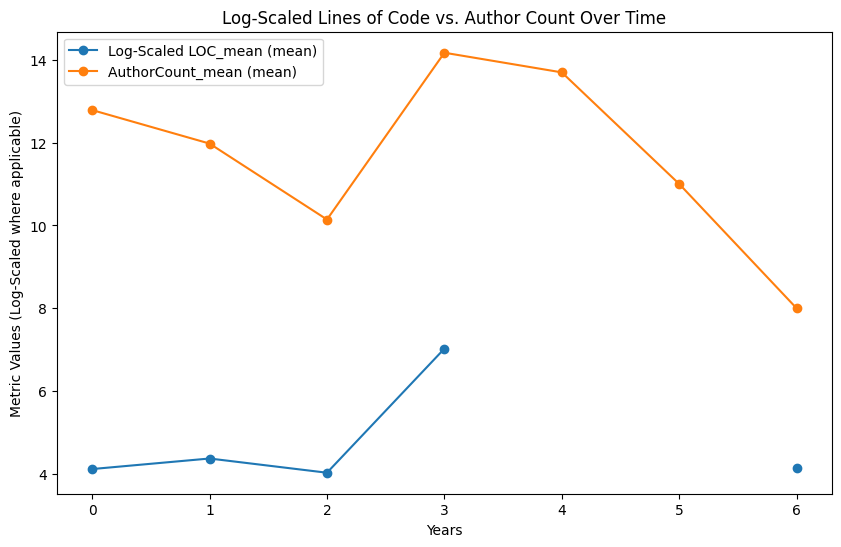

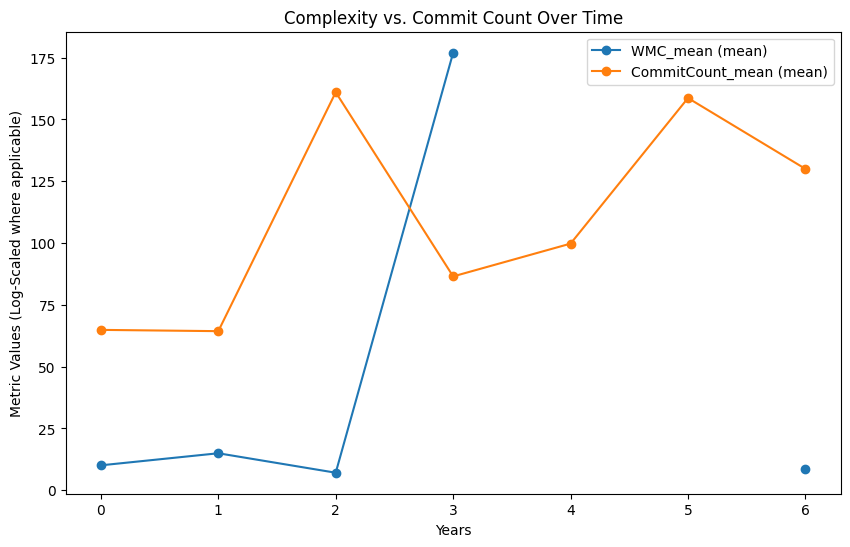

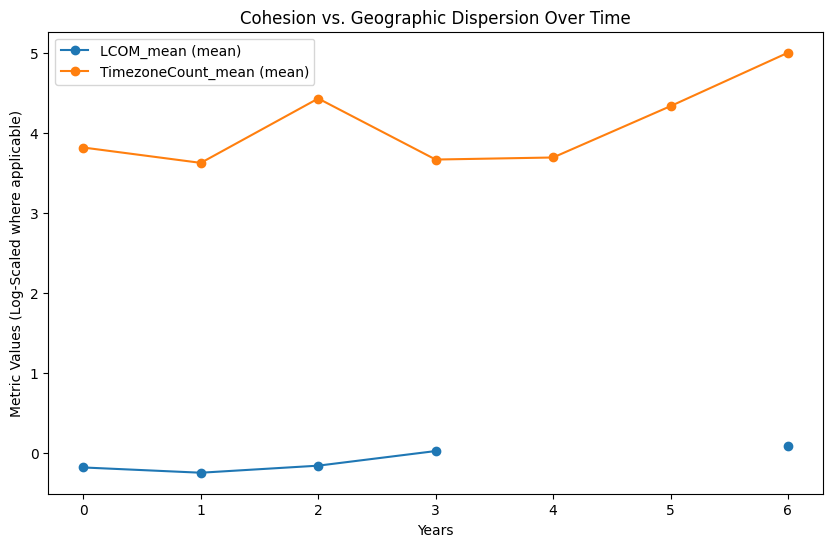

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Define metric pairs and titles for temporal visualization
temporal_pairs = [
    (['LOC_mean', 'AuthorCount_mean'], 'Log-Scaled Lines of Code vs. Author Count Over Time'),
    (['WMC_mean', 'CommitCount_mean'], 'Complexity vs. Commit Count Over Time'),
    (['LCOM_mean', 'TimezoneCount_mean'], 'Cohesion vs. Geographic Dispersion Over Time')
]

# Iterate through each pair to create separate temporal visualizations with standard deviation
for metrics, title in temporal_pairs:
    plt.figure(figsize=(10, 6))

    # Apply log transformation to metrics with high variance (if needed)
    transformed_metrics = []
    for metric in metrics:
        if metric == 'LOC_mean':  # Log-transform LOC to reduce scale
            merged_data[metric] = np.log1p(merged_data[metric])  # Use log1p to avoid log(0) issues
            transformed_metrics.append(f'Log-Scaled {metric}')
        else:
            transformed_metrics.append(metric)

    # Plot each metric over time with standard deviation
    for metric, transformed_metric in zip(metrics, transformed_metrics):
        # Calculate mean and standard deviation for each year
        yearly_data = merged_data.groupby('Year')[metric].agg(['mean', 'std']).reset_index()

        # Plot the mean line
        plt.plot(yearly_data['Year'], yearly_data['mean'], marker='o', label=f'{transformed_metric} (mean)')

        # Plot the standard deviation as shaded areas
        plt.fill_between(
            yearly_data['Year'],
            yearly_data['mean'] - yearly_data['std'],
            yearly_data['mean'] + yearly_data['std'],
            alpha=0.2  # Transparency for the shaded area
        )

    # Add labels and titles
    plt.xlabel("Years")
    plt.ylabel("Metric Values (Log-Scaled where applicable)")
    plt.title(title)
    plt.legend(loc='best')

    # Save and show the plot
    plt.savefig(f'/content/drive/MyDrive/Arquivos_Mestrado_Arthur_Ramires/Metodologia/AnalysisResults/Figures/temporal_{title.replace(" ", "_").lower()}.png')
    plt.show()


# Gráfico 1: Análise de Code Smells - Complexidade e Coesão

In [ ]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# Selecionar métricas relevantes para Code Smells
code_smell_metrics = ['LOC_mean', 'WMC_mean', 'LCOM_mean']

# Normalizar e aplicar K-means
scaler = StandardScaler()
normalized_data = scaler.fit_transform(merged_data[code_smell_metrics])
kmeans = KMeans(n_clusters=3, random_state=0)
merged_data['Cluster'] = kmeans.fit_predict(normalized_data)

# Configurar o gráfico de dispersão com escala logarítmica
plt.figure(figsize=(10, 6))
colors = ['#1f77b4', '#ff7f0e', '#2ca02c']
markers = ['o', '^', 's']

# Ajustar o fator de escala para o tamanho dos pontos
point_size_factor = 500

for cluster_id in range(3):
    cluster_data = merged_data[merged_data['Cluster'] == cluster_id]
    plt.scatter(
        cluster_data['LOC_mean'], cluster_data['WMC_mean'],
        s=(cluster_data['LCOM_mean'].abs() + 0.1) * point_size_factor,  # Tamanho ajustado, mantendo o mínimo > 0
        c=colors[cluster_id],
        marker=markers[cluster_id],
        label=f'Cluster {cluster_id}',
        alpha=0.7,
        edgecolors='k'
    )

# Configurar os eixos com escala logarítmica
plt.xscale('log')
plt.yscale('log')

# Adicionar margem aos eixos para melhorar a visualização
plt.xlim(left=merged_data['LOC_mean'].min() * 0.8, right=merged_data['LOC_mean'].max() * 1.2)
plt.ylim(bottom=merged_data['WMC_mean'].min() * 0.8, top=merged_data['WMC_mean'].max() * 1.2)

# Configurar rótulos e título
plt.xlabel('LOC (mean)')
plt.ylabel('WMC (mean)')
plt.title('Clustering of Code Smells: Complexity and Cohesion (Log Scale)')

# Posicionar a legenda no melhor local automaticamente
plt.legend(loc='best')

# Salvar a figura
plt.savefig('/content/drive/MyDrive/Arquivos_Mestrado_Arthur_Ramires/Metodologia/AnalysisResults/Figures/cluster_code_smells_log_scale_fixed.png')
plt.show()


ValueError: Input X contains NaN.
KMeans does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

In [ ]:
# Agora vamos explorar os clusters com base nas métricas de Community Smells
# As métricas selecionadas para esta análise são: 'CommitCount_mean', 'AuthorCount_mean', 'TimezoneCount_mean'

# Selecionar métricas relevantes para Community Smells
community_smell_metrics = ['CommitCount_mean', 'AuthorCount_mean', 'TimezoneCount_mean']

# Normalizar os dados das métricas selecionadas e aplicar K-means
normalized_community_data = scaler.fit_transform(merged_data[community_smell_metrics])
kmeans_community = KMeans(n_clusters=3, random_state=0)
merged_data['Community_Cluster'] = kmeans_community.fit_predict(normalized_community_data)

# Configurar o gráfico de dispersão para visualizar os clusters de Community Smells
plt.figure(figsize=(10, 6))
colors = ['#1f77b4', '#ff7f0e', '#2ca02c']
markers = ['o', '^', 's']

# Usar 'CommitCount_mean' e 'AuthorCount_mean' como eixos e 'TimezoneCount_mean' para o tamanho dos pontos
for cluster_id in range(3):
    cluster_data = merged_data[merged_data['Community_Cluster'] == cluster_id]
    plt.scatter(
        cluster_data['CommitCount_mean'], cluster_data['AuthorCount_mean'],
        s=(cluster_data['TimezoneCount_mean'].abs() + 1) * 50,  # Escala para melhorar a visualização
        c=colors[cluster_id],
        marker=markers[cluster_id],
        label=f'Cluster {cluster_id}',
        alpha=0.7,
        edgecolors='k'
    )

# Configurações do gráfico
plt.xlabel('Commit Count (mean)')
plt.ylabel('Author Count (mean)')
plt.title('Clustering of Community Smells: Activity and Diversity')
plt.legend(loc='upper right')
plt.savefig('/content/drive/MyDrive/Arquivos_Mestrado_Arthur_Ramires/Metodologia/AnalysisResults/Figures/cluster_community_smells_log_scale.png')

# Exibir o gráfico
plt.show()


# Gráfico 2: Análise de Community Smells - Atividade e Diversidade



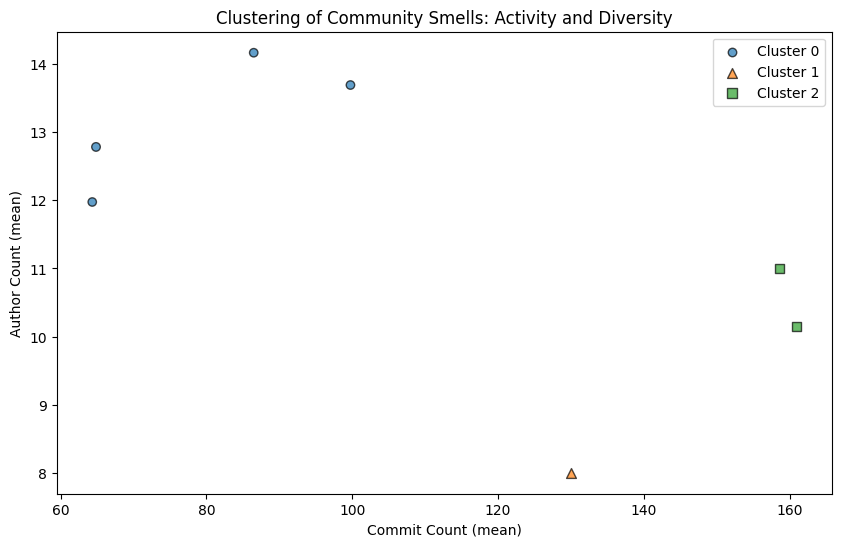

In [ ]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
# Selecionar métricas relevantes para Community Smells
community_smell_metrics = ['CommitCount_mean', 'AuthorCount_mean', 'TimezoneCount_mean']
temporal_summary = merged_data.copy()

# Preencher valores NaN com a média da coluna
temporal_summary[community_smell_metrics] = temporal_summary[community_smell_metrics].fillna(temporal_summary[community_smell_metrics].mean())
colors = ['#1f77b4', '#ff7f0e', '#2ca02c']
markers = ['o', '^', 's']
# Normalizar e aplicar K-means
scaler = StandardScaler()
normalized_data = scaler.fit_transform(temporal_summary[community_smell_metrics])
kmeans = KMeans(n_clusters=3, random_state=0)
temporal_summary['Cluster'] = kmeans.fit_predict(normalized_data)

# Plotar gráfico de dispersão
plt.figure(figsize=(10, 6))

for cluster_id in range(3):
    cluster_data = temporal_summary[temporal_summary['Cluster'] == cluster_id]
    plt.scatter(
        cluster_data['CommitCount_mean'], cluster_data['AuthorCount_mean'],
        s=cluster_data['TimezoneCount_mean'] * 10,  # Escalado pelo TimezoneCount
        c=colors[cluster_id],
        marker=markers[cluster_id],
        label=f'Cluster {cluster_id}',
        alpha=0.7,
        edgecolors='k'
    )

plt.xlabel('Commit Count (mean)')
plt.ylabel('Author Count (mean)')
plt.title('Clustering of Community Smells: Activity and Diversity')
plt.legend(loc='upper right')
plt.savefig('/content/drive/MyDrive/Arquivos_Mestrado_Arthur_Ramires/Metodologia/AnalysisResults/Figures/cluster_community_smells.png')
plt.show()


In [ ]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# Configuração das combinações de métricas e suas descrições
combinations = [
    (['WMC_mean', 'CommitCount_mean'], 'Complexity vs Activity'),
    (['LOC_mean', 'AuthorCount_mean'], 'Code Size vs Author Diversity'),
    (['LCOM_mean', 'TimezoneCount_mean'], 'Code Cohesion vs Geographic Dispersion')
]

# Diretório para salvar as imagens
save_dir = '/content/drive/MyDrive/Arquivos_Mestrado_Arthur_Ramires/Metodologia/AnalysisResults/Figures/'

for metrics, title in combinations:
    # Normalizar e aplicar K-means
    scaler = StandardScaler()
    normalized_data = scaler.fit_transform(merged_data[metrics])
    kmeans = KMeans(n_clusters=3, random_state=0)
    merged_data['Cluster'] = kmeans.fit_predict(normalized_data)

    # Ajuste de fator de escala do tamanho dos pontos
    if title == 'Complexity vs Activity':
        point_size_factor = 5  # Reduzido para evitar pontos muito grandes
    else:
        point_size_factor = 20  # Tamanho padrão para os outros gráficos

    # Configurar o gráfico de dispersão
    plt.figure(figsize=(10, 6))
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c']
    markers = ['o', '^', 's']

    for cluster_id in range(3):
        cluster_data = merged_data[merged_data['Cluster'] == cluster_id]
        plt.scatter(
            cluster_data[metrics[0]], cluster_data[metrics[1]],
            s=(cluster_data[metrics[1]].abs() + 1) * point_size_factor,  # Tamanho ajustado dos pontos
            c=colors[cluster_id],
            marker=markers[cluster_id],
            label=f'Cluster {cluster_id}',
            alpha=0.7,
            edgecolors='k'
        )

    # Configurar rótulos e título em inglês
    plt.xlabel(metrics[0])
    plt.ylabel(metrics[1])
    plt.title(f'Clustering of {title}')

    # Ajustar a posição da legenda para fora do gráfico com ícones menores
    if title == 'Complexity vs Activity':
        plt.legend(loc='center left', bbox_to_anchor=(1.05, 0.5), fontsize='small', frameon=False, markerscale=0.6)
        plt.subplots_adjust(right=0.85)  # Adicionar espaço para a legenda
    else:
        plt.legend(loc='best', fontsize='small', frameon=False)

    # Salvar a figura em inglês
    plt.savefig(f'{save_dir}cluster_{title.replace(" ", "_").lower()}.png')
    plt.show()


ValueError: Input X contains NaN.
KMeans does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

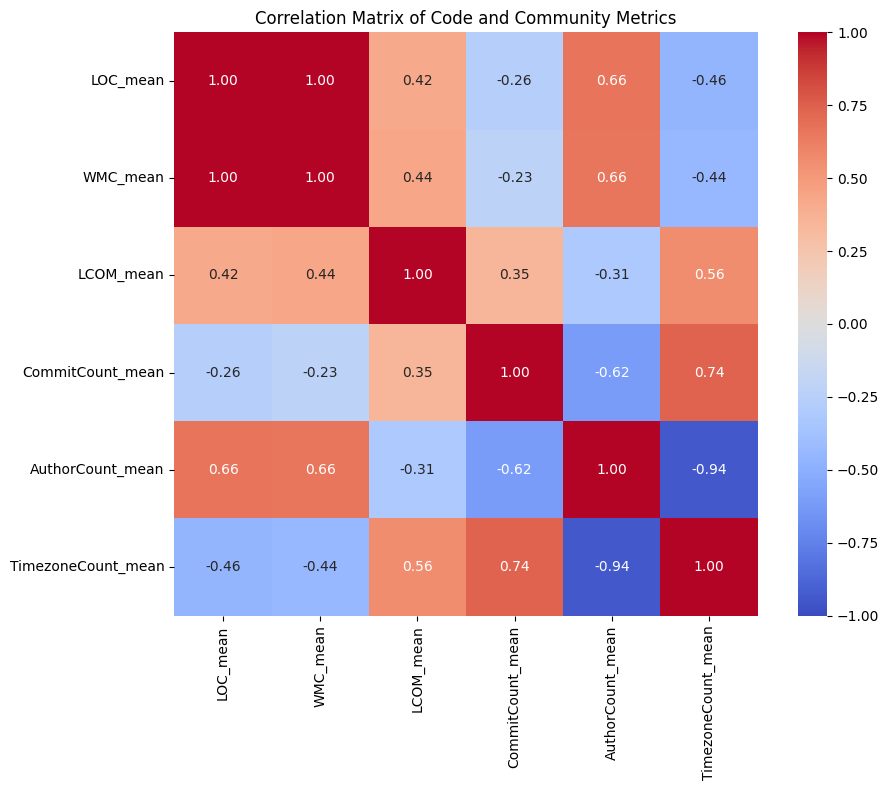

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Selecionar métricas de código e comunidade relevantes para a análise de correlação
metrics = [
    'LOC_mean', 'WMC_mean', 'LCOM_mean',    # Métricas de código
    'CommitCount_mean', 'AuthorCount_mean', 'TimezoneCount_mean'  # Métricas de comunidade
]

# Calcular a matriz de correlação
correlation_matrix = merged_data[metrics].corr()

# Plotar o heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, square=True, fmt=".2f")
plt.title("Correlation Matrix of Code and Community Metrics")

# Ajustar layout para evitar corte das labels
plt.tight_layout()

# Salvar a figura
plt.savefig(f'{save_dir}_heatmap.png')
plt.show()
